# Time Series Features

In [1]:
import sys
from utils import *
import tsfresh
from sklearn import preprocessing, decomposition, manifold

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
tourism = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibble\tourism.csv')
           .pipe(compute, lambda x: dict(date=pd.to_datetime(x.Quarter.str.replace(' ', ''))))
           .set_index('date', drop=False))
tourism

,Quarter,Region,State,Purpose,Trips,date
date,,,,,,
1998-01-01,1998 Q1,Adelaide,South Australia,Business,135.077690,1998-01-01
1998-04-01,1998 Q2,Adelaide,South Australia,Business,109.987316,1998-04-01
1998-07-01,1998 Q3,Adelaide,South Australia,Business,166.034687,1998-07-01
1998-10-01,1998 Q4,Adelaide,South Australia,Business,127.160464,1998-10-01
1999-01-01,1999 Q1,Adelaide,South Australia,Business,137.448533,1999-01-01
...,...,...,...,...,...,...
2016-10-01,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151,2016-10-01
2017-01-01,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014,2017-01-01
2017-04-01,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837,2017-04-01


In [4]:
tourism.groupby('Region State Purpose'.split()).Trips.mean()

Region           State            Purpose 
Adelaide         South Australia  Business    155.527910
                                  Holiday     156.543437
                                  Other        56.563450
                                  Visiting    205.193667
Adelaide Hills   South Australia  Business      2.664236
                                                 ...    
Wimmera          Victoria         Visiting     14.879986
Yorke Peninsula  South Australia  Business      6.892481
                                  Holiday      80.088485
                                  Other         1.885884
                                  Visiting     28.146552
Name: Trips, Length: 304, dtype: float64

In [5]:
(tourism
 .groupby('Region State Purpose'.split())
 .pipe(summarize, lambda x: dict(mean=x.Trips.mean()))
 .reset_index()
 .sort_values('mean'))

,Region,State,Purpose,mean
158,Kangaroo Island,South Australia,Other,0.340347
182,MacDonnell,Northern Territory,Other,0.449004
294,Wilderness West,Tasmania,Other,0.478268
34,Barkly,Northern Territory,Other,0.632386
86,Clare Valley,South Australia,Other,0.897749
...,...,...,...,...
269,Sydney,New South Wales,Holiday,550.326865
217,North Coast NSW,New South Wales,Holiday,587.896632
268,Sydney,New South Wales,Business,602.043884
199,Melbourne,Victoria,Visiting,618.897541


(tourism
 .groupby('Region State Purpose'.split())
 .Trips.quantile(np.linspace(0, 1, 5))
 .unstack()
 .reset_index())

### ACF features

In [6]:
(tourism
 .groupby('Region State Purpose'.split())
 .Trips
 .pipe(summarize, lambda x: dict(
     acf1 = x.shift().corr(x),
     acf10 = np.sum([x.shift(n).fillna(0).corr(x)**2 for n in range(1, 11)]),
     diff1_acf1 = x.diff().shift().corr(x.diff()),
     diff1_acf10 = np.sum([x.diff().shift(n).fillna(0).corr(x.diff().fillna(0))**2 for n in range(1, 11)]),
     diff2_acf1 = x.diff().diff().shift().corr(x.diff().diff()),
 ))
 .unstack()
 .reset_index())               

,Region,State,Purpose,acf1,acf10,diff1_acf1,diff1_acf10,diff2_acf1
0,Adelaide,South Australia,Business,0.033747,0.178512,-0.520696,0.467325,-0.680290
1,Adelaide,South Australia,Holiday,0.048006,0.181429,-0.362272,0.667445,-0.508050
2,Adelaide,South Australia,Other,0.520506,1.839437,-0.416583,0.394835,-0.683430
3,Adelaide,South Australia,Visiting,0.069183,0.087223,-0.400511,0.460148,-0.529266
4,Adelaide Hills,South Australia,Business,0.071204,0.118244,-0.579912,0.422009,-0.752904
...,...,...,...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.157857,0.074567,-0.399496,0.244883,-0.632037
300,Yorke Peninsula,South Australia,Business,0.031348,0.100111,-0.415320,0.319440,-0.578901
301,Yorke Peninsula,South Australia,Holiday,-0.005335,1.459052,-0.148840,2.271211,-0.260421
302,Yorke Peninsula,South Australia,Other,-0.108659,0.244080,-0.719777,0.973856,-0.796429


### STL features

In [7]:
d = (tourism
 .groupby('Region State Purpose'.split())
 .pipe(summarize, lambda x: dict(stl = sm.tsa.STL(x.Trips).fit()))
 .pipe(compute, lambda x: dict(trend_strength = [1 - (stl.resid.var() / (stl.resid + stl.trend).var()) for stl in x.stl],
                               season_strength = [1 - (stl.resid.var() / (stl.resid + stl.seasonal).var()) for stl in x.stl],))
 .reset_index()
 .drop(columns='stl'))
d

,Region,State,Purpose,trend_strength,season_strength
0,Adelaide,South Australia,Business,0.447547,0.460536
1,Adelaide,South Australia,Holiday,0.560649,0.663771
2,Adelaide,South Australia,Other,0.719917,0.328644
3,Adelaide,South Australia,Visiting,0.470850,0.555844
4,Adelaide Hills,South Australia,Business,0.483202,0.337481
...,...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.498420,0.453399
300,Yorke Peninsula,South Australia,Business,0.433322,0.556524
301,Yorke Peninsula,South Australia,Holiday,0.383127,0.831863
302,Yorke Peninsula,South Australia,Other,0.483537,0.557376


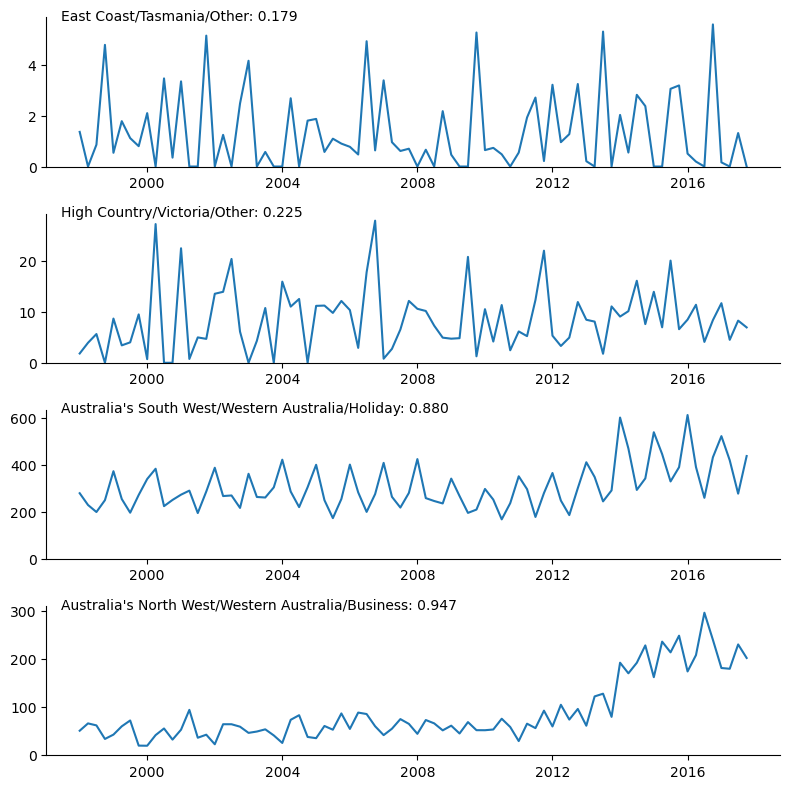

In [8]:
cols = 'Region State Purpose'.split()
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
ii = d.sort_values('trend_strength').index[[0, 1, -2, -1]]
for (ax, i) in zip(axs, ii):
    idx = d.loc[i, cols].to_frame().T
    ts = idx.merge(tourism, on=cols).set_index('date')
    ax.plot(ts.Trips)
    ax.text(.02, .98, f'{"/".join(idx.values[0])}: {d.trend_strength.loc[i]:.3f}', transform=ax.transAxes)
    ax.set(ylim=(0, None))
plt.tight_layout()

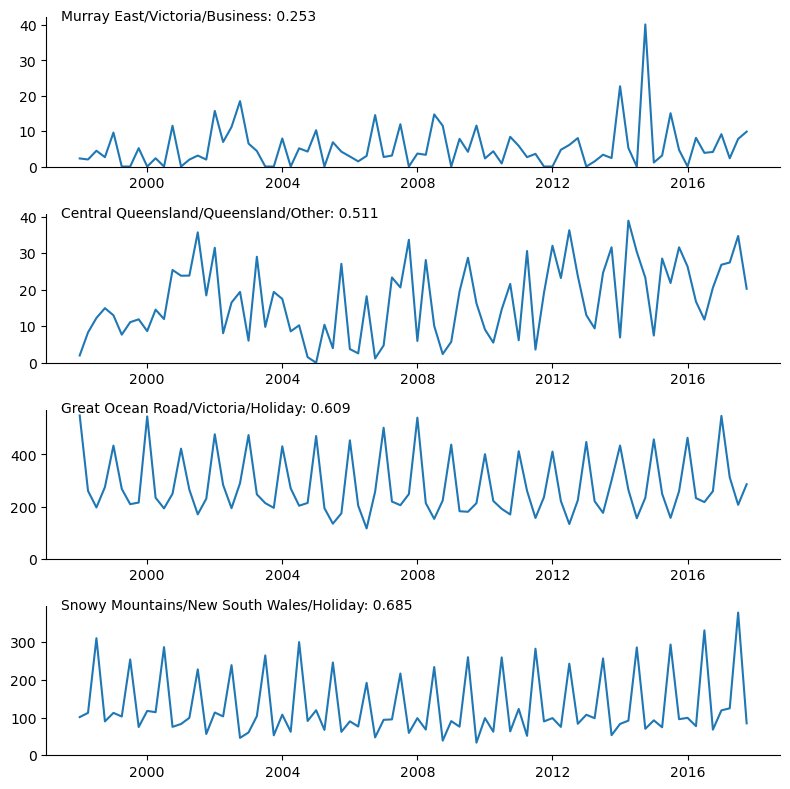

In [9]:
cols = 'Region State Purpose'.split()
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
ii = d.sort_values('season_strength').index[[0, 1, -2, -1]]
for (ax, i) in zip(axs, ii):
    idx = d.loc[i, cols].to_frame().T
    ts = idx.merge(tourism, on=cols).set_index('date')
    ax.plot(ts.Trips)
    ax.text(.02, .98, f'{"/".join(idx.values[0])}: {d.trend_strength.loc[i]:.3f}', transform=ax.transAxes)
    ax.set(ylim=(0, None))
plt.tight_layout()

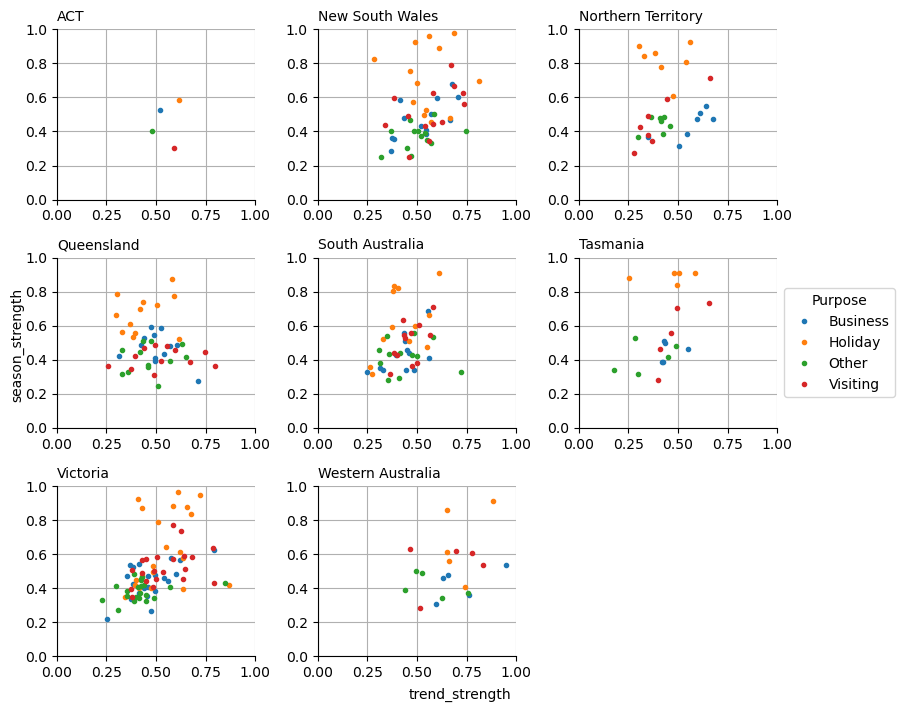

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(9,7))
axs = axs.ravel()
for (i, (State, dd)) in enumerate(d.groupby('State')):
    ax = axs[i]
    for (Purpose, ddd) in dd.groupby('Purpose'):
        ax.plot(ddd.trend_strength, ddd.season_strength, '.', label=Purpose)
    lim = (0, 1)
    ax.set(xlim=lim, ylim=lim, title=State)
    ax.grid()
axs[5].legend(title='Purpose', loc='center left', bbox_to_anchor=[1, .5])
fig.text(.5, -.01, 'trend_strength', ha='center', va='bottom')
fig.text(0, .5, 'season_strength', ha='left', va='center', rotation=90)
fig.delaxes(axs[-1])
plt.tight_layout()

### tsfresh

In [11]:
tourism

,Quarter,Region,State,Purpose,Trips,date
date,,,,,,
1998-01-01,1998 Q1,Adelaide,South Australia,Business,135.077690,1998-01-01
1998-04-01,1998 Q2,Adelaide,South Australia,Business,109.987316,1998-04-01
1998-07-01,1998 Q3,Adelaide,South Australia,Business,166.034687,1998-07-01
1998-10-01,1998 Q4,Adelaide,South Australia,Business,127.160464,1998-10-01
1999-01-01,1999 Q1,Adelaide,South Australia,Business,137.448533,1999-01-01
...,...,...,...,...,...,...
2016-10-01,2016 Q4,Yorke Peninsula,South Australia,Visiting,33.672151,2016-10-01
2017-01-01,2017 Q1,Yorke Peninsula,South Australia,Visiting,46.223014,2017-01-01
2017-04-01,2017 Q2,Yorke Peninsula,South Australia,Visiting,50.582837,2017-04-01


In [12]:
tourism.index.names = ['Date']
ids = list(zip(tourism.Region, tourism.State, tourism.Purpose))
d = pd.DataFrame(dict(date=tourism.date, ids=ids, Trips=tourism.Trips))
features = tsfresh.extract_features(d, column_id='ids', column_sort='date')

Feature Extraction: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 304 entries, ('Adelaide', 'South Australia', 'Business') to ('Yorke Peninsula', 'South Australia', 'Visiting')
Columns: 788 entries, Trips__variance_larger_than_standard_deviation to Trips__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(788)
memory usage: 1.8+ MB


In [14]:
feat = features.dropna(axis=1, how='all').copy()
feat = tsfresh.utilities.dataframe_functions.impute(feat)
feat

Trips__variance_larger_than_standard_deviation  \
Adelaide        South Australia Business                                             1.0   
                                Holiday                                              1.0   
                                Other                                                1.0   
                                Visiting                                             1.0   
Adelaide Hills  South Australia Business                                             1.0   
...                                                                                  ...   
Wimmera         Victoria        Visiting                                             1.0   
Yorke Peninsula South Australia Business                                             1.0   
                                Holiday                                              1.0   
                                Other                                                1.0   
                                Visiting                                             1.0   

                                          Trips__has_duplicate_max  \
Adelaide        South Australia Business                       0.0   
                                Holiday                        0.0   
                                Other                          0.0   
                                Visiting                       0.0   
Adelaide Hills  South Australia Business                       0.0   
...                                                            ...   
Wimmera         Victoria        Visiting                       0.0   
Yorke Peninsula South Australia Business                       0.0   
                                Holiday                        0.0   
                                Other                          0.0   
                                Visiting                       0.0   

                                          Trips__has_duplicate_min  \
Adelaide        South Australia Business                       0.0   
                                Holiday                        0.0   
                                Other                          0.0   
                                Visiting                       0.0   
Adelaide Hills  South Australia Business                       1.0   
...                                                            ...   
Wimmera         Victoria        Visiting                       0.0   
Yorke Peninsula South Australia Business                       1.0   
                                Holiday                        0.0   
                                Other                          1.0   
                                Visiting                       0.0   

                                          Trips__has_duplicate  \
Adelaide        South Australia Business                   0.0   
                                Holiday                    0.0   
                                Other                      0.0   
                                Visiting                   0.0   
Adelaide Hills  South Australia Business                   1.0   
...                                                        ...   
Wimmera         Victoria        Visiting                   0.0   
Yorke Peninsula South Australia Business                   1.0   
                                Holiday                    0.0   
                                Other                      1.0   
                                Visiting                   0.0   

                                          Trips__sum_values  \
Adelaide        South Australia Business       12442.232789   
                                Holiday        12523.474955   
                                Other           4525.075975   
                                Visiting       16415.493342   
Adelaide Hills  South Australia Business         213.138886   
...                                                     ...   
Wimmera         Victo

### Australian tourims data

In [15]:
d1 = (tourism
    .groupby('Region State Purpose'.split())
    .Trips.quantile(np.linspace(0, 1, 5))
    .unstack()
    .reset_index())

d2 = (tourism
    .groupby('Region State Purpose'.split())
    .Trips
    .pipe(summarize, lambda x: dict(
        acf1 = x.shift().corr(x),
        acf10 = np.sum([x.shift(n).fillna(0).corr(x)**2 for n in range(1,11)]),
        diff1_acf1 = x.diff().shift().corr(x.diff()),
        diff1_acf10 = np.sum([
            x.diff().shift(n).fillna(0).corr(x.diff().fillna(0))**2
            for n in range(1,11)]),
        diff2_acf1 = x.diff().diff().shift().corr(x.diff().diff()),))
    .unstack()
    .reset_index())

d3 = (tourism
    .groupby('Region State Purpose'.split())
    .pipe(summarize, lambda x: dict(
        stl = sm.tsa.STL(x.Trips).fit()))
    .pipe(compute, lambda x: dict(
        trend_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.trend).var())
            for stl in x.stl ],
        season_strength = [
            1 - (stl.resid.var() / (stl.resid + stl.seasonal).var())
            for stl in x.stl ],))
    .reset_index()
    .drop(columns='stl'))
cols = 'Region State Purpose'.split()
d = d1.merge(d2, on=cols).merge(d3, on=cols)

In [16]:
X = preprocessing.StandardScaler().fit_transform(d[d.columns[8:].astype(str)])
pca = decomposition.PCA().fit_transform(X)

In [17]:
dpca = (pd.DataFrame(pca)
        .assign(Region=d.Region, State=d.State, Purpose=d.Purpose))

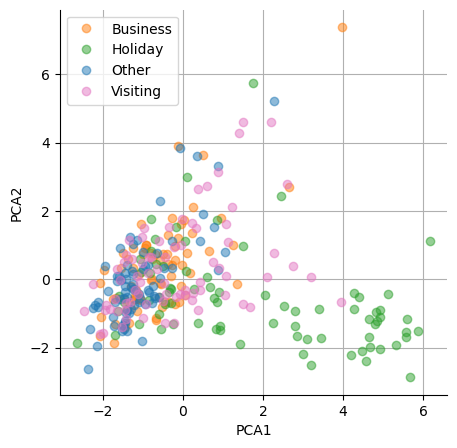

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
colors = dict(Business='C1', Holiday='C2', Other='C0', Visiting='C6')
for (Purpose, dd) in dpca.groupby('Purpose'):
    ax.plot(dd[0], dd[1], 'o', label=Purpose, color=colors[Purpose], alpha=.5)
ax.legend()
ax.set(xlabel='PCA1', ylabel='PCA2')
plt.grid()

### t-SNE

In [19]:
%%time
tsne = manifold.TSNE(random_state=1).fit_transform(X)

CPU times: total: 2.58 s
Wall time: 1.99 s


In [20]:
dtsne = (pd.DataFrame(tsne)
         .assign(Region=d.Region, State=d.State, Purpose=d.Purpose))

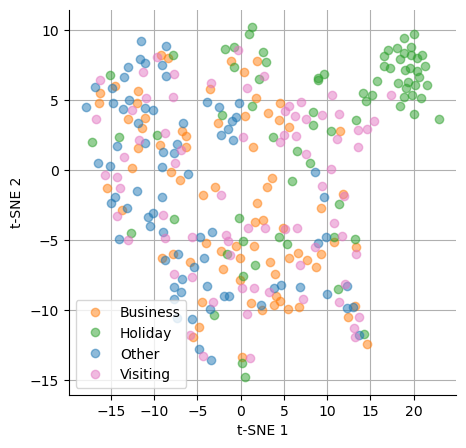

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
colors = dict(Business='C1', Holiday='C2', Other='C0', Visiting='C6')
for (Purpose, dd) in dtsne.groupby('Purpose'):
    ax.plot(dd[0], dd[1], 'o', label=Purpose, color=colors[Purpose], alpha=.5)
ax.legend()
ax.set(xlabel='t-SNE 1', ylabel='t-SNE 2')
plt.grid()